Dados consultados
http://terrabrasilis.dpi.inpe.br/app/dashboard/fires/biomes/aggregated/#

Import de bibliotecas

In [ ]:
!pip uninstall matplotlib -y
!pip uninstall pandas -y
!pip uninstall streamlit -y
!pip uninstall lightgbm -y
!pip uninstall numpy -y
!pip uninstall numba -y
!pip uninstall pycaret -y
!pip uninstall scikit-learn -y
!pip uninstall xgboost -y
!pip uninstall scikit-learn -y
!pip install matplotlib==3.3.4
!pip install pandas==1.3.3
!pip install streamlit==1.19.0
!pip install lightgbm==3.2.1
!pip install numpy==1.19.5
!pip install numba==0.53.1
!pip install pycaret#==2.3.10
!pip install scikit-learn==0.23.2
!pip install xgboost==1.7.4

In [19]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import pycaret
from pycaret.regression import *
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import requests
import numpy as np

Import arquivo

In [2]:
df = pd.read_csv("dados_queimadas.csv",delimiter=";")
df.shape

(1617, 4)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     1617 non-null   object
 1   class    1617 non-null   object
 2   focuses  1617 non-null   int64 
 3   uf       1617 non-null   object
dtypes: int64(1), object(3)
memory usage: 50.7+ KB


Considerar apenas desmatamento recente

In [3]:
df['class'].unique()

array(['Desmatamento Consolidado', 'Desmatamento Recente', 'Floresta',
       'Outros', 'Vegetacao Secundaria'], dtype=object)

In [7]:
desm_recente = df[df['class']=="Desmatamento Recente"]
desm_recente.drop(columns=['class'],inplace=True)
desm_recente

,date,focuses,uf
9,2023/01,2,ACRE
10,2023/01,22,AMAZONAS
11,2023/01,3,MARANHÃO
12,2023/01,29,MATO GROSSO
13,2023/01,31,PARÁ
...,...,...,...
1591,2019/12,106,MATO GROSSO
1592,2019/12,556,PARÁ
1593,2019/12,29,RONDÔNIA
1594,2019/12,3,RORAIMA


In [38]:
#total de casos de incêndio
print(desm_recente['focuses'].sum())
#mês mais antigo
print(desm_recente['date'].min())
#mês mais recente
print(desm_recente['date'].max())

182029
2019/08
2023/04


Criar df com as latitudes e longitudes de cada estado

In [8]:
lista_estados = desm_recente['uf'].unique()

In [9]:
latitude_longitude = {
    'Estado': ['ACRE', 'ALAGOAS', 'AMAPÁ', 'AMAZONAS', 'BAHIA', 'CEARÁ', 'DISTRITO FEDERAL', 'ESPÍRITO SANTO',
               'GOIÁS', 'MARANHÃO', 'MATO GROSSO', 'MATO GROSSO DO SUL', 'MINAS GERAIS', 'PARÁ', 'PARAÍBA',
               'PARANÁ', 'PERNAMBUCO', 'PIAUÍ', 'RIO DE JANEIRO', 'RIO GRANDE DO NORTE', 'RIO GRANDE DO SUL',
               'RONDÔNIA', 'RORAIMA', 'SANTA CATARINA', 'SÃO PAULO', 'SERGIPE', 'TOCANTINS'],
    'Latitude': [-8.77, -9.62, 1.41, -3.47, -12.96, -3.71, -15.83, -19.19, -16.64, -2.55, -12.64, -20.51, -18.10,
                 -3.38, -7.24, -25.44, -8.28, -6.60, -22.25, -5.81, -30.17, -11.22, 1.89, -27.33, -23.55, -10.57, -9.46],
    'Longitude': [-70.55, -35.73, -51.77, -62.80, -38.51, -38.54, -47.86, -40.34, -49.31, -44.30, -55.42, -54.54,
                  -44.38, -52.21, -36.78, -49.29, -35.07, -42.82, -43.17, -35.20, -53.53, -63.90, -61.94, -51.95,
                  -46.64, -37.68, -48.49]
}

latitude_longitude= pd.DataFrame(latitude_longitude)
print(latitude_longitude)

                 Estado  Latitude  Longitude
0                  ACRE     -8.77     -70.55
1               ALAGOAS     -9.62     -35.73
2                 AMAPÁ      1.41     -51.77
3              AMAZONAS     -3.47     -62.80
4                 BAHIA    -12.96     -38.51
5                 CEARÁ     -3.71     -38.54
6      DISTRITO FEDERAL    -15.83     -47.86
7        ESPÍRITO SANTO    -19.19     -40.34
8                 GOIÁS    -16.64     -49.31
9              MARANHÃO     -2.55     -44.30
10          MATO GROSSO    -12.64     -55.42
11   MATO GROSSO DO SUL    -20.51     -54.54
12         MINAS GERAIS    -18.10     -44.38
13                 PARÁ     -3.38     -52.21
14              PARAÍBA     -7.24     -36.78
15               PARANÁ    -25.44     -49.29
16           PERNAMBUCO     -8.28     -35.07
17                PIAUÍ     -6.60     -42.82
18       RIO DE JANEIRO    -22.25     -43.17
19  RIO GRANDE DO NORTE     -5.81     -35.20
20    RIO GRANDE DO SUL    -30.17     -53.53
21        

Capturar os dados Históricos de Metereologia de cada estado através das referências de latitude e longitude

In [10]:
df_hist = pd.DataFrame()

for estado in lista_estados:
  info_estado = latitude_longitude[latitude_longitude['Estado']==estado]
  latitude = info_estado['Latitude'].astype(float).values[0]
  longitude = info_estado['Longitude'].astype(float).values[0]
  url_hist = f"https://archive-api.open-meteo.com/v1/archive?timezone=auto&latitude={latitude}&longitude={longitude}&start_date=2010-01-01&end_date=2023-05-26&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,precipitation_hours,et0_fao_evapotranspiration"
  response = requests.get(url_hist)
  data = response.json()
  df_estado = pd.DataFrame(data['daily'])
  df_estado['Estado'] = estado
  df_hist = df_hist.append(df_estado)

Removendo registros null

In [11]:
df_hist = df_hist.dropna()

In [12]:
df_hist.isnull().sum()

time                          0
temperature_2m_max            0
temperature_2m_min            0
temperature_2m_mean           0
precipitation_sum             0
rain_sum                      0
precipitation_hours           0
et0_fao_evapotranspiration    0
Estado                        0
dtype: int64

Consultando previsão dos dados metereológicos

In [13]:
df_prev = pd.DataFrame()

for estado in lista_estados:
  info_estado = latitude_longitude[latitude_longitude['Estado']==estado]
  latitude = info_estado['Latitude'].astype(float).values[0]
  longitude = info_estado['Longitude'].astype(float).values[0]
  url_hist = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m,precipitation&daily=temperature_2m_min,temperature_2m_max,precipitation_sum&timezone=auto"
  response = requests.get(url_hist)
  data = response.json()
  df_estado = pd.DataFrame(data['daily'])
  df_estado['Estado'] = estado
  df_prev = df_hist.append(df_estado)

In [14]:
df_prev.isnull().sum()

time                          0
temperature_2m_max            0
temperature_2m_min            0
temperature_2m_mean           7
precipitation_sum             0
rain_sum                      7
precipitation_hours           7
et0_fao_evapotranspiration    7
Estado                        0
dtype: int64

In [15]:
df_prev = df_prev.dropna()

Tratamento do campo de data do df de previsão para ficar no mesmo formato que o df principal

In [16]:
df_prev['date'] = df_prev['time'].str.slice(0,7)
df_prev['date'] = df_prev['date'].str.replace("-","/")
df_prev['date']

0       2010/01
1       2010/01
2       2010/01
3       2010/01
4       2010/01
         ...   
4889    2023/05
4890    2023/05
4891    2023/05
4892    2023/05
4893    2023/05
Name: date, Length: 44046, dtype: object

Agrupando os dados diários por mês e cruzando com a base principal

In [17]:
df_prev_agrupado = df_prev.groupby(['Estado', 'date']).agg({'temperature_2m_max': 'mean', 'temperature_2m_min': 'mean','temperature_2m_mean':'mean','precipitation_sum':'sum','rain_sum':'sum','precipitation_hours':'sum','et0_fao_evapotranspiration': 'mean'}).reset_index()
desm_recente = desm_recente.rename(columns={'uf':'Estado'})
df_cruzamento = df_prev_agrupado.merge(desm_recente , on=['Estado','date'], how='left')

Remover dados históricos muito antigos onde não temos dados de desmatamento, e separar os dados históricos dos previstos

In [18]:
df_cruzamento = df_cruzamento[df_cruzamento['date']>='2019/08']

Colunando dados históricos dos últimos 26 meses

In [54]:
#formatação do campo de date e preenchimento com dados de zero queimadas para o mês que não tivemos ocorrências
df_cruzamento['focuses'] = df_cruzamento['focuses'].fillna(0)
df_cruzamento['date'] = pd.to_datetime(df_cruzamento['date'], format='%Y-%m')

#dicionário para armazenar os valores das variáveis
variaveis_dict = {'Estado': [], 'date': []}

#nomes das variáveis 
variaveis = ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum',
             'rain_sum', 'precipitation_hours', 'et0_fao_evapotranspiration', 'focuses']

#dicionário
for variavel in variaveis:
    for j in range(1, 15):
        variaveis_dict[f'{variavel}_M{j}'] = []

#loop pelos registros
for i, linha in df_cruzamento.iterrows():
    #obtendo os dados do registro atual
    estado = linha['Estado']
    date = linha['date']

    #adicionando 'Estado' e 'date' ao variaveis_dict
    variaveis_dict['Estado'].append(estado)
    variaveis_dict['date'].append(date)

    #loop pelos últimos 30 meses
    for j in range(1, 15):
        #data do mês anterior
        mes_anterior = date - pd.DateOffset(months=j)
        
        #busca do registro do mês anterior para o estado atual
        registro_mes_anterior = df_cruzamento[(df_cruzamento['Estado'] == estado) & (df_cruzamento['date'] == mes_anterior)]
        
        #verificar se há registro do mês anterior
        if len(registro_mes_anterior) > 0:
            #obter os valores das variáveis desejadas do mês anterior
            var_values = registro_mes_anterior[variaveis].values[0]
        else:
            #se não houver registro do mês anterior, use valores de preenchimento
            var_values = [np.nan]*len(variaveis) 
            
        #preencher as variáveis no dicionário
        for k in range(len(variaveis)):
            variavel_nome = f'{variaveis[k]}_M{j}'
            variaveis_dict[variavel_nome].append(var_values[k])
    
#criando DataFrame a partir do dicionário de variáveis
novo_df = pd.DataFrame(variaveis_dict)

#juntando o novo df ao df original
novo_df= novo_df.drop_duplicates(subset=['Estado','date'])
df_final = df_cruzamento.merge(novo_df,on=['Estado','date'],how="left")
df_final = df_final.dropna()
df_final

,Estado,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,precipitation_hours,et0_fao_evapotranspiration,focuses,...,focuses_M5,focuses_M6,focuses_M7,focuses_M8,focuses_M9,focuses_M10,focuses_M11,focuses_M12,focuses_M13,focuses_M14
14,ACRE,2020-10-01,32.167742,22.980645,26.770968,135.5,135.5,134.0,4.544516,1137.0,...,25.0,0.0,0.0,0.0,12.0,1.0,26.0,233.0,2048.0,2071.0
15,ACRE,2020-11-01,30.923333,23.043333,26.313333,288.1,288.1,154.0,4.202333,88.0,...,41.0,25.0,0.0,0.0,0.0,12.0,1.0,26.0,233.0,2048.0
16,ACRE,2020-12-01,29.532258,22.532258,25.235484,199.3,199.3,271.0,3.648387,9.0,...,207.0,41.0,25.0,0.0,0.0,0.0,12.0,1.0,26.0,233.0
17,ACRE,2021-01-01,29.038710,22.383871,24.941935,237.9,237.9,284.0,3.390323,4.0,...,2413.0,207.0,41.0,25.0,0.0,0.0,0.0,12.0,1.0,26.0
18,ACRE,2021-02-01,28.942857,22.542857,25.010714,296.0,296.0,334.0,3.372857,0.0,...,2279.0,2413.0,207.0,41.0,25.0,0.0,0.0,0.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,TOCANTINS,2023-01-01,30.009677,22.148387,25.625806,171.3,171.3,330.0,4.267097,1.0,...,2.0,5.0,2.0,5.0,0.0,0.0,2.0,0.0,0.0,2.0
410,TOCANTINS,2023-02-01,31.164286,23.135714,26.728571,79.3,79.3,192.0,4.605357,1.0,...,4.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0,0.0,0.0
411,TOCANTINS,2023-03-01,29.919355,22.522581,25.667742,273.5,273.5,344.0,3.875484,0.0,...,11.0,4.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0,0.0
412,TOCANTINS,2023-04-01,30.993333,23.050000,26.720000,78.0,78.0,144.0,4.373667,0.0,...,0.0,11.0,4.0,2.0,5.0,2.0,5.0,0.0,0.0,2.0


Separação de dados que serão utilizados como histórico (de Abril/23 para trás) aproveitados treino e dados que serão utilizados como oportunidade para prevermos as qtde de queimadas, pois ainda não existe no site do governo dados desse tema de Maio para frente.

In [59]:
df_futuro =  df_final[df_final['date'] > pd.to_datetime('2023-04-01')]
df_passado =  df_final[(df_final['date'] >= pd.to_datetime('2019-08-01')) & (df_final['date'] <= pd.to_datetime('2023-04-01'))]

Transformação da variável de estado em dummy

In [60]:
df_passado_dummy = pd.get_dummies(df_passado, columns=['Estado'], drop_first=True)
df_futuro_dummy = pd.get_dummies(df_futuro, columns=['Estado'], drop_first=True)

Inserir variável que marcará quando for o governo Lula

In [61]:
df_passado_dummy['lula'] = df_passado_dummy['date'].apply(lambda x: 1 if x >= pd.to_datetime('2023-01-01') else 0)
df_futuro_dummy['lula'] = 1

In [62]:
df_passado_dummy['lula'].unique()

array([0, 1])

Análises preliminares antes da criaçãod o modelo

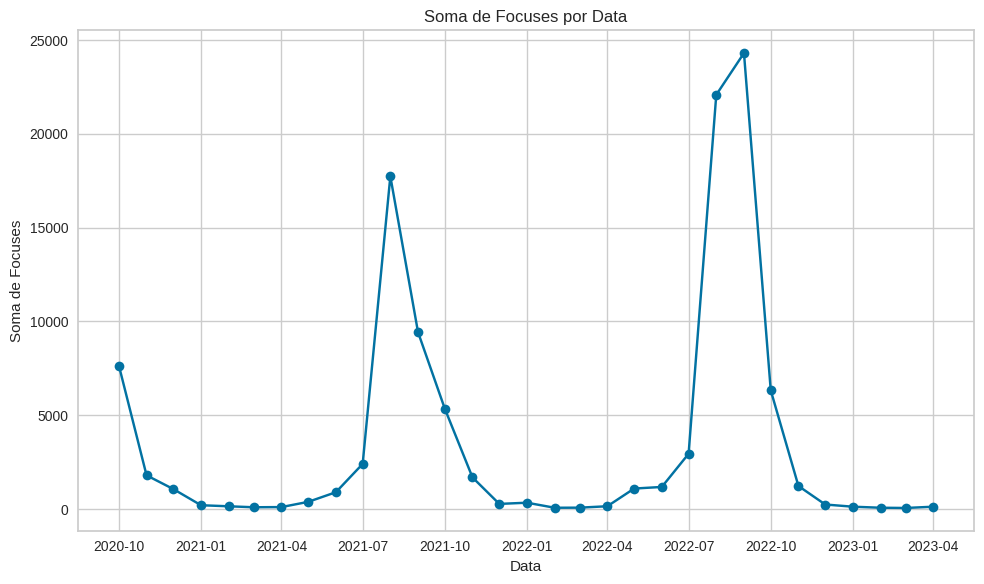

In [63]:
#agrupando os dados pela data e calcule a soma do campo 'focuses'
grouped_df = df_passado_dummy.copy()
# Converte a coluna 'date' para datetime, se ainda não estiver
grouped_df['date'] = pd.to_datetime(grouped_df['date'])
grouped_df = grouped_df.groupby('date')['focuses'].sum().reset_index()

#criação do gráfico de linha 
plt.figure(figsize=(10,6)) # Define o tamanho da figura
plt.plot_date(grouped_df['date'], grouped_df['focuses'], linestyle='solid')
plt.title('Soma de Focuses por Data')
plt.xlabel('Data')
plt.ylabel('Soma de Focuses')
plt.tight_layout()
plt.show()

É possível notar que as queimadas apresentam um padrão, com grandes picos a partir de Julho até Outubro, podemos aproveitar esse padrão para inserir uma variável que traga o peso que estes meses possuem em relação as queimadas. Mas antes vamos verificar das variáveis já existentes na base, quais podemos retirar.

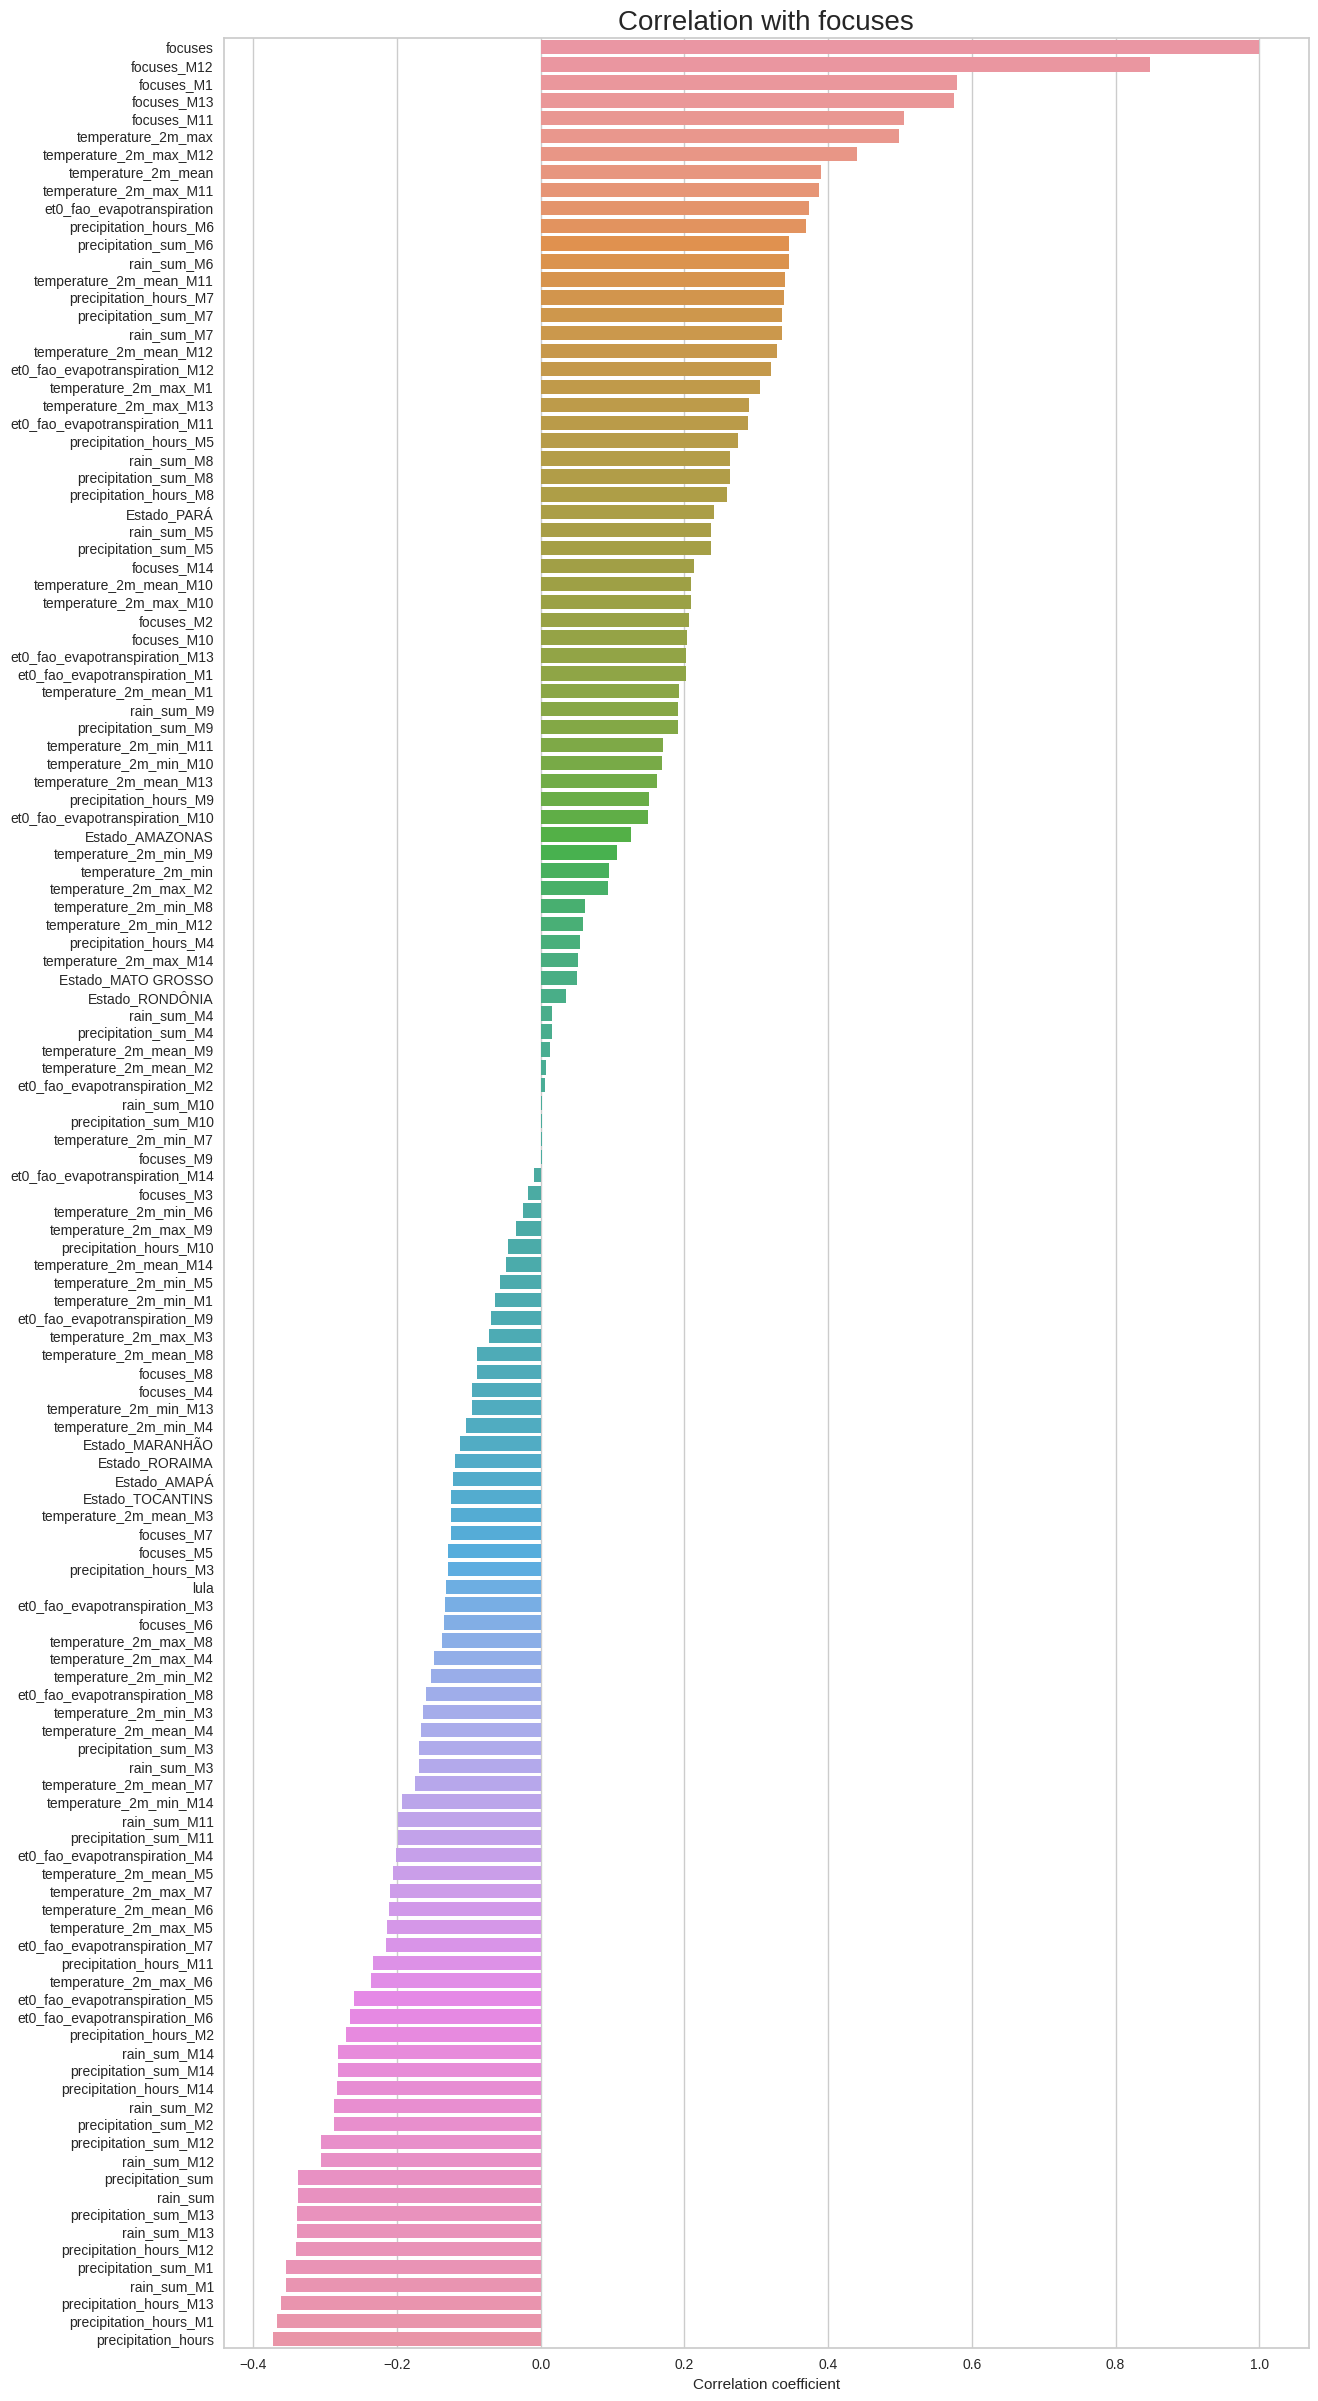

In [64]:
# Calcular a correlação
correlations = df_passado_dummy.corr()['focuses'].sort_values(ascending=False)

# Criar uma figura matplotlib
plt.figure(figsize=(14, 30))

# Plotar um gráfico de barras com os valores de correlação
sns.barplot(x=correlations.values, y=correlations.index)

plt.title('Correlation with focuses', fontsize=20)
plt.xlabel('Correlation coefficient')
plt.show()

As variáveis mais importantes para o modelo dizem respeito a própria variável principal de qtd de queimadas e de temperatura máxima nos meses próximos ao mês atual e períodos que se assemelham ao do registro em anos anteriores, justamente por refletirem de sazonalidade que observamos. Portanto, iremos excluir demais variáveis do modelo e iremos potencializar a variável mais importante de quantidade de queimadas nos 3 últimos meses e nos 6 últimos meses.

In [65]:
df_passado_dummy['ult_6_meses_focuses'] = df_passado_dummy['focuses_M1'] + df_passado_dummy['focuses_M2'] + df_passado_dummy['focuses_M3'] + df_passado_dummy['focuses_M4'] + df_passado_dummy['focuses_M5'] + df_passado_dummy['focuses_M6'] 
df_passado_dummy['ult_3_meses_focuses'] = df_passado_dummy['focuses_M1'] + df_passado_dummy['focuses_M2'] + df_passado_dummy['focuses_M3'] 

df_futuro_dummy['ult_6_meses_focuses'] = df_futuro_dummy['focuses_M1'] + df_futuro_dummy['focuses_M2'] + df_futuro_dummy['focuses_M3'] + df_futuro_dummy['focuses_M4'] + df_futuro_dummy['focuses_M5'] + df_futuro_dummy['focuses_M6'] 
df_futuro_dummy['ult_3_meses_focuses'] = df_futuro_dummy['focuses_M1'] + df_futuro_dummy['focuses_M2'] + df_futuro_dummy['focuses_M3'] 

Agora iremos retirar as demais variaveis inclusas na base que não agregaram tanto na correlação.

In [90]:
df_passado_dummy2 = df_passado_dummy.drop(columns=['precipitation_sum_M1',
 'precipitation_sum_M2',
 'precipitation_sum_M3',
 'precipitation_sum_M4',
 'precipitation_sum_M5',
 'precipitation_sum_M6',
 'precipitation_sum_M7',
 'precipitation_sum_M8',
 'precipitation_sum_M9',
 'precipitation_sum_M10',
 'precipitation_sum_M11',
 'precipitation_sum_M12',
 'precipitation_sum_M13',
 'precipitation_sum_M14',
#  'precipitation_sum_M15',
#  'precipitation_sum_M16',
#  'precipitation_sum_M17',
#  'precipitation_sum_M18',
#  'precipitation_sum_M19',
#  'precipitation_sum_M20',
#  'precipitation_sum_M21',
#  'precipitation_sum_M22',
#  'precipitation_sum_M23',
 'rain_sum_M1',
 'rain_sum_M2',
 'rain_sum_M3',
 'rain_sum_M4',
 'rain_sum_M5',
 'rain_sum_M6',
 'rain_sum_M7',
 'rain_sum_M8',
 'rain_sum_M9',
 'rain_sum_M10',
 'rain_sum_M11',
 'rain_sum_M12',
 'rain_sum_M13',
 'rain_sum_M14',
#  'rain_sum_M15',
#  'rain_sum_M16',
#  'rain_sum_M17',
#  'rain_sum_M18',
#  'rain_sum_M19',
#  'rain_sum_M20',
#  'rain_sum_M21',
#  'rain_sum_M22',
#  'rain_sum_M23',
 'precipitation_hours_M1',
 'precipitation_hours_M2',
 'precipitation_hours_M3',
 'precipitation_hours_M4',
 'precipitation_hours_M5',
 'precipitation_hours_M6',
 'precipitation_hours_M7',
 'precipitation_hours_M8',
 'precipitation_hours_M9',
 'precipitation_hours_M10',
 'precipitation_hours_M11',
 'precipitation_hours_M12',
 'precipitation_hours_M13',
 'precipitation_hours_M14',
#  'precipitation_hours_M15',
#  'precipitation_hours_M16',
#  'precipitation_hours_M17',
#  'precipitation_hours_M18',
#  'precipitation_hours_M19',
#  'precipitation_hours_M20',
#  'precipitation_hours_M21',
#  'precipitation_hours_M22',
#  'precipitation_hours_M23',
 'et0_fao_evapotranspiration_M1',
 'et0_fao_evapotranspiration_M2',
 'et0_fao_evapotranspiration_M3',
 'et0_fao_evapotranspiration_M4',
 'et0_fao_evapotranspiration_M5',
 'et0_fao_evapotranspiration_M6',
 'et0_fao_evapotranspiration_M7',
 'et0_fao_evapotranspiration_M8',
 'et0_fao_evapotranspiration_M9',
 'et0_fao_evapotranspiration_M10',
 'et0_fao_evapotranspiration_M11',
 'et0_fao_evapotranspiration_M12',
 'et0_fao_evapotranspiration_M13',
 'et0_fao_evapotranspiration_M14',
#  'et0_fao_evapotranspiration_M15',
#  'et0_fao_evapotranspiration_M16',
#  'et0_fao_evapotranspiration_M17',
#  'et0_fao_evapotranspiration_M18',
#  'et0_fao_evapotranspiration_M19',
#  'et0_fao_evapotranspiration_M20',
#  'et0_fao_evapotranspiration_M21',
#  'et0_fao_evapotranspiration_M22',
#  'et0_fao_evapotranspiration_M23',
  'temperature_2m_min_M1',
 'temperature_2m_min_M2',
 'temperature_2m_min_M3',
 'temperature_2m_min_M4',
 'temperature_2m_min_M5',
 'temperature_2m_min_M6',
 'temperature_2m_min_M7',
 'temperature_2m_min_M8',
 'temperature_2m_min_M9',
 'temperature_2m_min_M10',
 'temperature_2m_min_M11',
 'temperature_2m_min_M12',
 'temperature_2m_min_M13',
 'temperature_2m_min_M14',
#  'temperature_2m_min_M15',
#  'temperature_2m_min_M16',
#  'temperature_2m_min_M17',
#  'temperature_2m_min_M18',
#  'temperature_2m_min_M19',
#  'temperature_2m_min_M20',
#  'temperature_2m_min_M21',
#  'temperature_2m_min_M22',
#  'temperature_2m_min_M23',
 'temperature_2m_mean_M1',
 'temperature_2m_mean_M2',
 'temperature_2m_mean_M3',
 'temperature_2m_mean_M4',
 'temperature_2m_mean_M5',
 'temperature_2m_mean_M6',
 'temperature_2m_mean_M7',
 'temperature_2m_mean_M8',
 'temperature_2m_mean_M9',
 'temperature_2m_mean_M10',
 'temperature_2m_mean_M11',
 'temperature_2m_mean_M12',
 'temperature_2m_mean_M13',
 'temperature_2m_mean_M14',
#  'temperature_2m_mean_M15',
#  'temperature_2m_mean_M16',
#  'temperature_2m_mean_M17',
#  'temperature_2m_mean_M18',
#  'temperature_2m_mean_M19',
#  'temperature_2m_mean_M20',
#  'temperature_2m_mean_M21',
#  'temperature_2m_mean_M22',
#  'temperature_2m_mean_M23', 
 'precipitation_sum',
  'rain_sum',
 'precipitation_hours',
 'temperature_2m_max_M4',
 'temperature_2m_max_M5',
 'temperature_2m_max_M6',
 'temperature_2m_max_M7',
 'temperature_2m_max_M8',
 'temperature_2m_max_M9',
 'temperature_2m_max_M10',
  # 'temperature_2m_max_M15',
#  'temperature_2m_max_M16',
#  'temperature_2m_max_M17',
#  'temperature_2m_max_M18',
#  'temperature_2m_max_M19',
#  'temperature_2m_max_M20',
 'focuses_M4',
 'focuses_M5',
 'focuses_M6',
 'focuses_M7',
 'focuses_M8',
 'focuses_M9',
 'focuses_M10',
 'focuses_M14',
#  'focuses_M15',
#  'focuses_M16',
#  'focuses_M17',
#  'focuses_M18',
#  'focuses_M19',
#  'focuses_M20',
  'temperature_2m_min',
 'temperature_2m_mean',
 'et0_fao_evapotranspiration',
#   'precipitation_sum_M24',
#  'precipitation_sum_M25',
#  'rain_sum_M24',
#  'rain_sum_M25',
#  'precipitation_hours_M24',
#  'precipitation_hours_M25',
#  'et0_fao_evapotranspiration_M24',
#  'et0_fao_evapotranspiration_M25',
#   'precipitation_sum_M24',
#  'precipitation_sum_M25',
#  'rain_sum_M24',
#  'rain_sum_M25',
#  'precipitation_hours_M24',
#  'precipitation_hours_M25',
#  'et0_fao_evapotranspiration_M24',
#  'et0_fao_evapotranspiration_M25',
#   'temperature_2m_min_M24',
#  'temperature_2m_min_M25',
#  'temperature_2m_mean_M24',
#  'temperature_2m_mean_M25',
  'temperature_2m_max_M14',
#  'temperature_2m_max_M15',
#   'temperature_2m_max_M21',
#  'temperature_2m_max_M22',
#   'focuses_M21',
#  'focuses_M22',
 ])

Iremos fazer as mesmas exclusões para o df de previsão

In [91]:
df_futuro_dummy2 = df_futuro_dummy.drop(columns=['precipitation_sum_M1',
 'precipitation_sum_M2',
 'precipitation_sum_M3',
 'precipitation_sum_M4',
 'precipitation_sum_M5',
 'precipitation_sum_M6',
 'precipitation_sum_M7',
 'precipitation_sum_M8',
 'precipitation_sum_M9',
 'precipitation_sum_M10',
 'precipitation_sum_M11',
 'precipitation_sum_M12',
 'precipitation_sum_M13',
 'precipitation_sum_M14',
#  'precipitation_sum_M15',
#  'precipitation_sum_M16',
#  'precipitation_sum_M17',
#  'precipitation_sum_M18',
#  'precipitation_sum_M19',
#  'precipitation_sum_M20',
#  'precipitation_sum_M21',
#  'precipitation_sum_M22',
#  'precipitation_sum_M23',
 'rain_sum_M1',
 'rain_sum_M2',
 'rain_sum_M3',
 'rain_sum_M4',
 'rain_sum_M5',
 'rain_sum_M6',
 'rain_sum_M7',
 'rain_sum_M8',
 'rain_sum_M9',
 'rain_sum_M10',
 'rain_sum_M11',
 'rain_sum_M12',
 'rain_sum_M13',
 'rain_sum_M14',
#  'rain_sum_M15',
#  'rain_sum_M16',
#  'rain_sum_M17',
#  'rain_sum_M18',
#  'rain_sum_M19',
#  'rain_sum_M20',
#  'rain_sum_M21',
#  'rain_sum_M22',
#  'rain_sum_M23',
 'precipitation_hours_M1',
 'precipitation_hours_M2',
 'precipitation_hours_M3',
 'precipitation_hours_M4',
 'precipitation_hours_M5',
 'precipitation_hours_M6',
 'precipitation_hours_M7',
 'precipitation_hours_M8',
 'precipitation_hours_M9',
 'precipitation_hours_M10',
 'precipitation_hours_M11',
 'precipitation_hours_M12',
 'precipitation_hours_M13',
 'precipitation_hours_M14',
#  'precipitation_hours_M15',
#  'precipitation_hours_M16',
#  'precipitation_hours_M17',
#  'precipitation_hours_M18',
#  'precipitation_hours_M19',
#  'precipitation_hours_M20',
#  'precipitation_hours_M21',
#  'precipitation_hours_M22',
#  'precipitation_hours_M23',
 'et0_fao_evapotranspiration_M1',
 'et0_fao_evapotranspiration_M2',
 'et0_fao_evapotranspiration_M3',
 'et0_fao_evapotranspiration_M4',
 'et0_fao_evapotranspiration_M5',
 'et0_fao_evapotranspiration_M6',
 'et0_fao_evapotranspiration_M7',
 'et0_fao_evapotranspiration_M8',
 'et0_fao_evapotranspiration_M9',
 'et0_fao_evapotranspiration_M10',
 'et0_fao_evapotranspiration_M11',
 'et0_fao_evapotranspiration_M12',
 'et0_fao_evapotranspiration_M13',
 'et0_fao_evapotranspiration_M14',
#  'et0_fao_evapotranspiration_M15',
#  'et0_fao_evapotranspiration_M16',
#  'et0_fao_evapotranspiration_M17',
#  'et0_fao_evapotranspiration_M18',
#  'et0_fao_evapotranspiration_M19',
#  'et0_fao_evapotranspiration_M20',
#  'et0_fao_evapotranspiration_M21',
#  'et0_fao_evapotranspiration_M22',
#  'et0_fao_evapotranspiration_M23',
  'temperature_2m_min_M1',
 'temperature_2m_min_M2',
 'temperature_2m_min_M3',
 'temperature_2m_min_M4',
 'temperature_2m_min_M5',
 'temperature_2m_min_M6',
 'temperature_2m_min_M7',
 'temperature_2m_min_M8',
 'temperature_2m_min_M9',
 'temperature_2m_min_M10',
 'temperature_2m_min_M11',
 'temperature_2m_min_M12',
 'temperature_2m_min_M13',
 'temperature_2m_min_M14',
#  'temperature_2m_min_M15',
#  'temperature_2m_min_M16',
#  'temperature_2m_min_M17',
#  'temperature_2m_min_M18',
#  'temperature_2m_min_M19',
#  'temperature_2m_min_M20',
#  'temperature_2m_min_M21',
#  'temperature_2m_min_M22',
#  'temperature_2m_min_M23',
 'temperature_2m_mean_M1',
 'temperature_2m_mean_M2',
 'temperature_2m_mean_M3',
 'temperature_2m_mean_M4',
 'temperature_2m_mean_M5',
 'temperature_2m_mean_M6',
 'temperature_2m_mean_M7',
 'temperature_2m_mean_M8',
 'temperature_2m_mean_M9',
 'temperature_2m_mean_M10',
 'temperature_2m_mean_M11',
 'temperature_2m_mean_M12',
 'temperature_2m_mean_M13',
 'temperature_2m_mean_M14',
#  'temperature_2m_mean_M15',
#  'temperature_2m_mean_M16',
#  'temperature_2m_mean_M17',
#  'temperature_2m_mean_M18',
#  'temperature_2m_mean_M19',
#  'temperature_2m_mean_M20',
#  'temperature_2m_mean_M21',
#  'temperature_2m_mean_M22',
#  'temperature_2m_mean_M23', 
 'precipitation_sum',
  'rain_sum',
 'precipitation_hours',
 'temperature_2m_max_M4',
 'temperature_2m_max_M5',
 'temperature_2m_max_M6',
 'temperature_2m_max_M7',
 'temperature_2m_max_M8',
 'temperature_2m_max_M9',
 'temperature_2m_max_M10',
  # 'temperature_2m_max_M15',
#  'temperature_2m_max_M16',
#  'temperature_2m_max_M17',
#  'temperature_2m_max_M18',
#  'temperature_2m_max_M19',
#  'temperature_2m_max_M20',
 'focuses_M4',
 'focuses_M5',
 'focuses_M6',
 'focuses_M7',
 'focuses_M8',
 'focuses_M9',
 'focuses_M10',
 'focuses_M14',
#  'focuses_M15',
#  'focuses_M16',
#  'focuses_M17',
#  'focuses_M18',
#  'focuses_M19',
#  'focuses_M20',
  'temperature_2m_min',
 'temperature_2m_mean',
 'et0_fao_evapotranspiration',
#   'precipitation_sum_M24',
#  'precipitation_sum_M25',
#  'rain_sum_M24',
#  'rain_sum_M25',
#  'precipitation_hours_M24',
#  'precipitation_hours_M25',
#  'et0_fao_evapotranspiration_M24',
#  'et0_fao_evapotranspiration_M25',
#   'precipitation_sum_M24',
#  'precipitation_sum_M25',
#  'rain_sum_M24',
#  'rain_sum_M25',
#  'precipitation_hours_M24',
#  'precipitation_hours_M25',
#  'et0_fao_evapotranspiration_M24',
#  'et0_fao_evapotranspiration_M25',
#   'temperature_2m_min_M24',
#  'temperature_2m_min_M25',
#  'temperature_2m_mean_M24',
#  'temperature_2m_mean_M25',
  'temperature_2m_max_M14',
#  'temperature_2m_max_M15',
#   'temperature_2m_max_M21',
#  'temperature_2m_max_M22',
#   'focuses_M21',
#  'focuses_M22',
 ])

Variáveis mantidas

In [92]:
df_passado_dummy2.columns.to_list()

['date',
 'temperature_2m_max',
 'focuses',
 'temperature_2m_max_M1',
 'temperature_2m_max_M2',
 'temperature_2m_max_M3',
 'temperature_2m_max_M11',
 'temperature_2m_max_M12',
 'temperature_2m_max_M13',
 'focuses_M1',
 'focuses_M2',
 'focuses_M3',
 'focuses_M11',
 'focuses_M12',
 'focuses_M13',
 'Estado_AMAPÁ',
 'Estado_AMAZONAS',
 'Estado_MARANHÃO',
 'Estado_MATO GROSSO',
 'Estado_PARÁ',
 'Estado_RONDÔNIA',
 'Estado_RORAIMA',
 'Estado_TOCANTINS',
 'lula',
 'ult_6_meses_focuses',
 'ult_3_meses_focuses']

Também trabalharemos um pouco mais de feature engineering comparando o mês anterior (referência mais recente) com os dois últimos meses e com os meses próximos ao perído atual em anos anteriores.

In [93]:
df_passado_dummy2['delta_focuses_M2'] = df_passado_dummy2['focuses_M2'] - df_passado_dummy2['focuses_M1'] 
df_passado_dummy2['delta_focuses_M3'] = df_passado_dummy2['focuses_M3'] - df_passado_dummy2['focuses_M1'] 
df_passado_dummy2['delta_focuses_M11'] = df_passado_dummy2['focuses_M11'] - df_passado_dummy2['focuses_M1'] 
df_passado_dummy2['delta_focuses_M12'] = df_passado_dummy2['focuses_M12'] - df_passado_dummy2['focuses_M1'] 
df_passado_dummy2['delta_focuses_M13'] = df_passado_dummy2['focuses_M13'] - df_passado_dummy2['focuses_M1'] 
# df_passado_dummy2['delta_focuses_M23'] = df_passado_dummy2['focuses_M23'] - df_passado_dummy2['focuses_M1'] 
# df_passado_dummy2['delta_focuses_M24'] = df_passado_dummy2['focuses_M24'] - df_passado_dummy2['focuses_M1'] 
# df_passado_dummy2['delta_focuses_M25'] = df_passado_dummy2['focuses_M25'] - df_passado_dummy2['focuses_M1'] 

df_futuro_dummy2['delta_focuses_M2'] = df_futuro_dummy2['focuses_M2'] - df_futuro_dummy2['focuses_M1'] 
df_futuro_dummy2['delta_focuses_M3'] = df_futuro_dummy2['focuses_M3'] - df_futuro_dummy2['focuses_M1'] 
df_futuro_dummy2['delta_focuses_M11'] = df_futuro_dummy2['focuses_M11'] - df_futuro_dummy2['focuses_M1'] 
df_futuro_dummy2['delta_focuses_M12'] = df_futuro_dummy2['focuses_M12'] - df_futuro_dummy2['focuses_M1'] 
df_futuro_dummy2['delta_focuses_M13'] = df_futuro_dummy2['focuses_M13'] - df_futuro_dummy2['focuses_M1'] 
# df_futuro_dummy2['delta_focuses_M23'] = df_futuro_dummy2['focuses_M23'] - df_futuro_dummy2['focuses_M1'] 
# df_futuro_dummy2['delta_focuses_M24'] = df_futuro_dummy2['focuses_M24'] - df_futuro_dummy2['focuses_M1'] 
# df_futuro_dummy2['delta_focuses_M25'] = df_futuro_dummy2['focuses_M25'] - df_futuro_dummy2['focuses_M1'] 

Tratamento do campo de data e separação do ano de mês

In [94]:
df_passado_dummy2['mes'] = df_passado_dummy2['date'].dt.month
df_passado_dummy2['ano'] = df_passado_dummy2['date'].dt.year
df_passado_dummy2 = df_passado_dummy2.drop(columns=['date'])

df_futuro_dummy2['mes'] = df_futuro_dummy2['date'].dt.month
df_futuro_dummy2['ano'] = df_futuro_dummy2['date'].dt.year
df_futuro_dummy2 = df_futuro_dummy2.drop(columns=['date'])

Atribuição do peso aos meses de maior representatividade

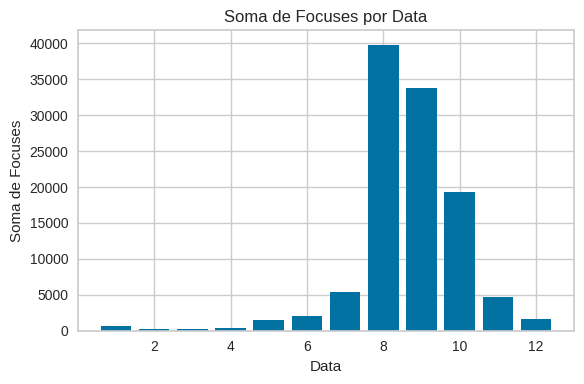

In [95]:
#Agrupamento dos dados pela mês e calculo da soma do campo 'focuses'
grouped_df = df_passado_dummy2.groupby('mes')['focuses'].sum().reset_index()

plt.figure(figsize=(6,4)) 
plt.bar(grouped_df['mes'], grouped_df['focuses'])
plt.title('Soma de Focuses por Data')
plt.xlabel('Data')
plt.ylabel('Soma de Focuses')

plt.tight_layout()
plt.show()

Agora que temos o peso de importância que cada mês possui em relação a quantidade total de incêndios ocorridas iremos replicar estes pesos para a nossa base de treino de acordo com o mês de cada registro

In [96]:
#Agrupamento 
queimadas_por_mes = df_passado_dummy2.groupby('mes')['focuses'].sum()

#calculo do total de queimadas
total_queimadas = df_passado_dummy2['focuses'].sum()

#o quanto cada mês representa em relação ao total
peso_mes = queimadas_por_mes / total_queimadas

#convertendo a série em um df e resetando o índice para transformar 'mes' em uma coluna novamente
peso_mes_df = peso_mes.reset_index()
peso_mes_df.columns = ['mes', 'peso']

#Join para a base de treino e a base de previsão
df_passado_dummy2 = pd.merge(df_passado_dummy2, peso_mes_df, on='mes', how='left')
df_futuro_dummy2 = pd.merge(df_futuro_dummy2, peso_mes_df, on='mes', how='left')

Verificar novamente a correlação

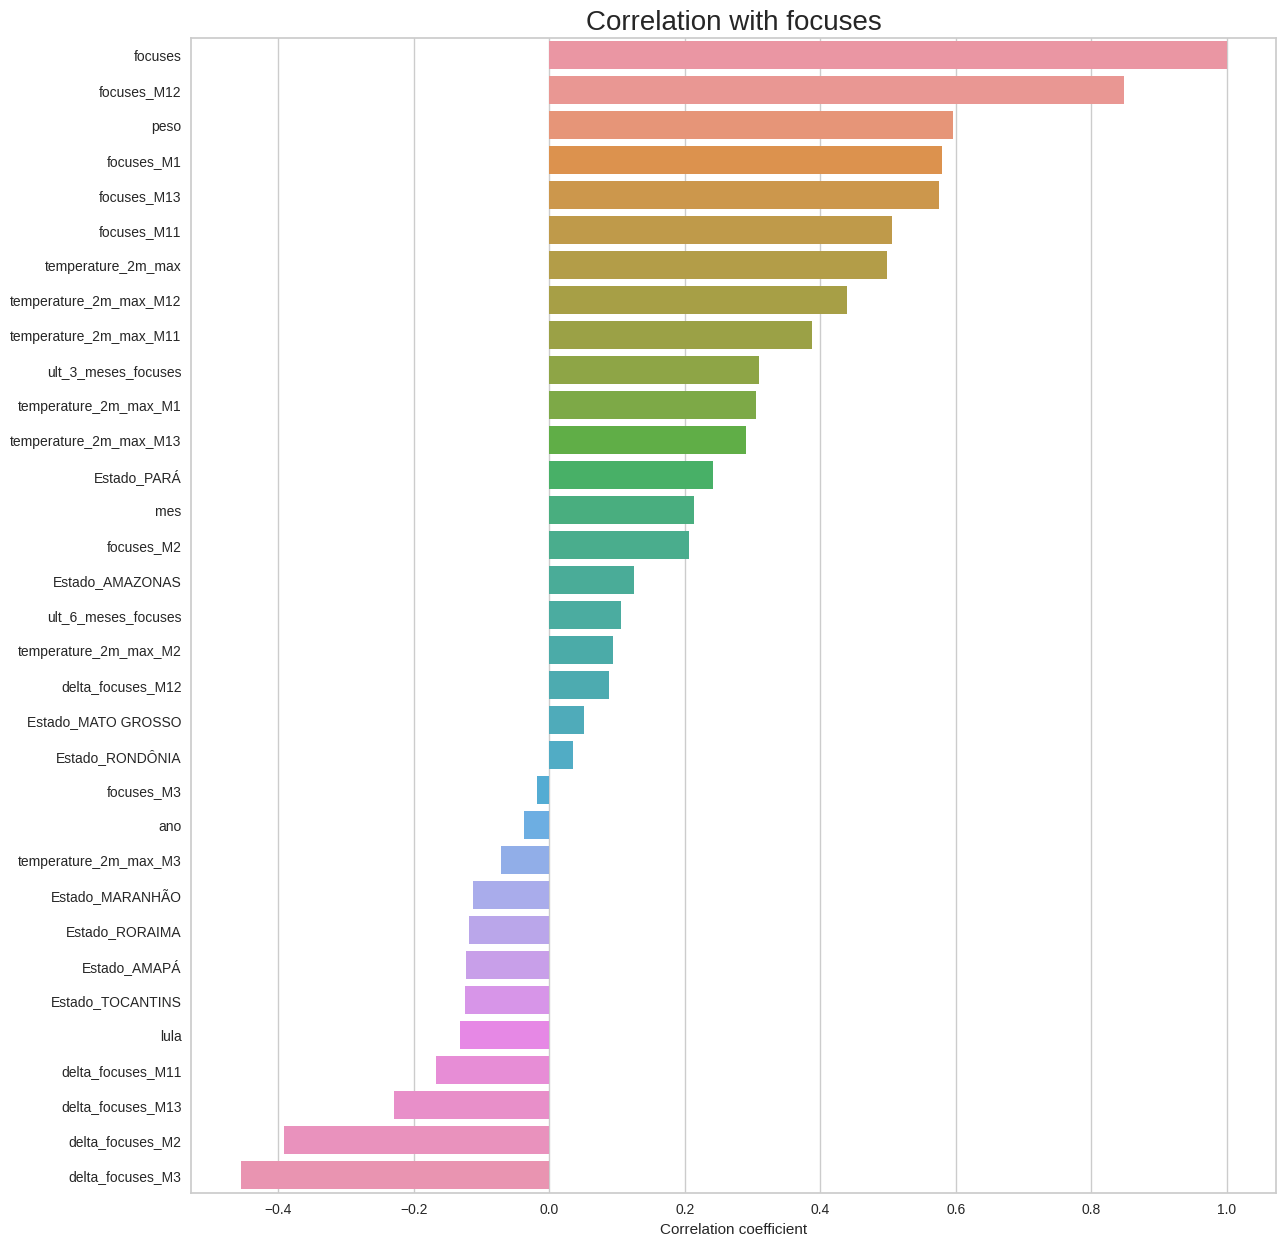

In [97]:
correlations = df_passado_dummy2.corr()['focuses'].sort_values(ascending=False)
plt.figure(figsize=(14, 15))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Correlation with focuses', fontsize=20)
plt.xlabel('Correlation coefficient')
plt.show()

Criação do modelo

In [98]:
df_futuro_dummy2[(df_futuro_dummy2['ano']==2023)&(df_futuro_dummy2['mes']>=5)]

,temperature_2m_max,focuses,temperature_2m_max_M1,temperature_2m_max_M2,temperature_2m_max_M3,temperature_2m_max_M11,temperature_2m_max_M12,temperature_2m_max_M13,focuses_M1,focuses_M2,...,ult_6_meses_focuses,ult_3_meses_focuses,delta_focuses_M2,delta_focuses_M3,delta_focuses_M11,delta_focuses_M12,delta_focuses_M13,mes,ano,peso
0,28.650000,0.0,28.926667,29.225806,28.732143,28.470000,28.629032,29.130000,0.0,0.0,...,139.0,0.0,0.0,0.0,43.0,24.0,5.0,5,2023,0.013499
1,29.069231,0.0,29.253333,29.122581,27.621429,28.896667,27.590323,28.086667,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2023,0.013499
2,29.761538,0.0,30.226667,30.064516,29.014286,29.006667,29.377419,29.920000,1.0,0.0,...,286.0,12.0,-1.0,10.0,21.0,5.0,0.0,5,2023,0.013499
3,29.519231,0.0,28.620000,27.970968,28.292857,29.106667,28.680645,28.330000,0.0,1.0,...,42.0,2.0,1.0,1.0,12.0,7.0,0.0,5,2023,0.013499
4,31.896154,0.0,29.680000,28.793548,30.357143,31.680000,31.467742,30.963333,92.0,18.0,...,433.0,149.0,-74.0,-53.0,842.0,890.0,38.0,5,2023,0.013499
5,29.526923,0.0,29.140000,28.677419,28.832143,29.226667,29.364516,29.153333,2.0,2.0,...,518.0,12.0,0.0,6.0,126.0,23.0,8.0,5,2023,0.013499
6,28.661538,0.0,28.530000,28.525806,28.346429,28.840000,29.151613,28.886667,10.0,4.0,...,330.0,22.0,-6.0,-2.0,30.0,36.0,-5.0,5,2023,0.013499
7,28.973077,0.0,31.013333,30.616129,28.439286,27.703333,27.629032,28.193333,23.0,35.0,...,113.0,63.0,12.0,-18.0,-23.0,-23.0,-22.0,5,2023,0.013499
8,31.480769,0.0,30.993333,29.919355,31.164286,32.570000,31.912903,30.973333,0.0,0.0,...,3.0,1.0,0.0,1.0,2.0,5.0,0.0,5,2023,0.013499


In [50]:
# !pip uninstall numpy==1.23.5
# !pip install numpy==1.23.5
# from pycaret.regression import setup

In [99]:
s = setup(data = df_passado_dummy2, 
          target = 'focuses', 
          remove_outliers = False,
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,focuses
2,Target type,Regression
3,Original data shape,"(279, 33)"
4,Transformed data shape,"(279, 33)"
5,Transformed train set shape,"(195, 33)"
6,Transformed test set shape,"(84, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


In [100]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [101]:
best_model = compare_models(sort = 'r2', errors = 'raise')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,173.7184,278756.2876,431.2215,0.7057,0.8999,1.6697,0.7050
xgboost,Extreme Gradient Boosting,200.1916,352416.8236,500.6466,0.6893,1.0732,1.7354,0.2390
dt,Decision Tree Regressor,212.6966,439943.2508,517.9634,0.6701,1.1046,1.6435,0.0850
ada,AdaBoost Regressor,227.9929,283383.6431,465.0752,0.6612,2.5039,12.8639,0.2530
lightgbm,Light Gradient Boosting Machine,294.5268,479777.8083,568.5413,0.6287,2.2951,14.7702,0.2350
knn,K Neighbors Regressor,234.1455,501268.0949,577.4870,0.6029,1.2852,1.9438,0.0890
huber,Huber Regressor,185.9780,317135.0056,494.8792,0.5968,1.0003,1.9380,0.1240
omp,Orthogonal Matching Pursuit,227.7338,334785.9444,507.2969,0.5716,2.3013,9.6443,0.1430
rf,Random Forest Regressor,190.1028,370782.8075,498.2647,0.5554,1.0167,2.0208,0.5530
gbr,Gradient Boosting Regressor,189.2845,308552.6246,485.0638,0.5470,1.1477,1.7220,0.3050


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Considerando que os meses de pico na base apresentam uma quantdade de próxima de 25.000 queimadas, o erro apresentado do MAE de 173 e 200 para os dois primeiros modelos parece ser bem aceitável, assim como o RMSE destes dois modelos rodando perto de 450 e com um r² interessante de 0.7. 

Seguiremos então com o modelo de Xgboost e o Extra Trees Regressor

In [102]:
#create model xgboost
mdl_xg = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,153.9913,148587.6875,385.4707,0.7589,1.3005,1.7917
1,90.3570,66337.3125,257.5603,0.8561,1.0140,2.7263
2,255.3251,408596.4375,639.2155,0.1528,1.2553,2.1095
3,74.0287,25484.9004,159.6399,0.8966,0.9381,0.8496
4,89.4464,98649.7031,314.0855,0.8547,0.9722,0.6071
5,389.9337,1082897.6250,1040.6237,0.7767,0.9648,1.0531
6,92.8804,59096.7188,243.0982,0.7632,1.1521,2.9997
7,406.0834,691108.7500,831.3295,0.4552,0.9346,1.2799
8,372.0492,910575.0625,954.2405,0.5669,0.9244,1.9419


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [103]:
#create model gbc
mdl_et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,136.1935,91243.9570,302.0661,0.8519,1.1803,1.7908
1,74.8635,50745.4157,225.2674,0.8900,0.9370,2.4591
2,130.5805,102342.5393,319.9102,0.7878,0.9514,1.6503
3,87.2685,35910.2867,189.5001,0.8543,0.5826,0.7487
4,83.0360,65773.6511,256.4637,0.9031,0.5943,0.7652
5,510.7995,1657534.6229,1287.4528,0.6582,0.9882,3.0884
6,114.6489,75629.5660,275.0083,0.6970,1.2608,3.1898
7,214.9221,220483.1157,469.5563,0.8262,0.6208,0.7240
8,256.4847,263996.8812,513.8063,0.8744,0.7604,1.1640


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

O modelo et apresentou um melhor r², contudo apresentou um desvio padrão um pouco maior desta métrica do que o xg.

Nas métricas de MAE, RMSE e MSE o et continuou apresentando melhor desempenho tanto na métrica, quanto no desvio padrão.

In [104]:
tuned_xg = tune_model(mdl_xg)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,173.9071,316653.9375,562.7202,0.4862,1.4610,1.9694
1,43.9811,13183.9434,114.8214,0.9714,1.0364,2.6408
2,156.5639,284672.7188,533.5473,0.4097,0.9202,0.7491
3,134.7510,76691.0781,276.9315,0.6888,1.0006,1.5556
4,170.2280,261996.3281,511.8558,0.6141,0.8131,0.8590
5,429.4341,1212857.7500,1101.2982,0.7499,0.8442,1.8052
6,55.6735,11601.0645,107.7082,0.9535,1.1615,2.5087
7,236.1289,281117.7812,530.2054,0.7784,0.8861,1.0030
8,250.0894,239609.5781,489.4993,0.8860,0.9255,1.2620


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [105]:
tuned_et = tune_model(mdl_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,167.7795,80581.8186,283.8694,0.8692,2.5027,12.3232
1,99.6659,27505.1772,165.8468,0.9404,2.2057,22.7054
2,130.1293,71637.3742,267.6516,0.8515,1.6951,4.1489
3,132.4445,35482.4645,188.3679,0.8560,2.3126,12.1684
4,139.1821,159785.9262,399.7323,0.7646,2.0174,4.9331
5,611.0698,2593551.0674,1610.4506,0.4651,1.7960,8.6235
6,142.3690,31767.8320,178.2353,0.8727,2.1211,22.3164
7,255.1557,242785.5830,492.7328,0.8086,1.7850,14.7583
8,348.6641,755579.9163,869.2410,0.6406,2.0187,13.3426


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Agora com os modelos tunados o XG apresentou melhor desempenho em quase todas as métricas de erro. Contudo, o r² do et subiu para 0.77 com um desvio padrão mais baixo ainda do que o ada.

In [106]:
for tuned_mdl in [tuned_et,tuned_xg]:
  print(tuned_mdl)
  display(tuned_mdl.get_params())
  print('')

ExtraTreesRegressor(bootstrap=True, max_depth=6, max_features='log2',
                    min_impurity_decrease=0.0002, min_samples_leaf=2,
                    n_estimators=290, n_jobs=-1, random_state=123)


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0002,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 290,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=70, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=123, ...)


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 70,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 123,
 'reg_alpha': 0.3,
 'reg_lambda': 4,
 'sampling_method': None,
 'scale_pos_weight': 47.900000000000006,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

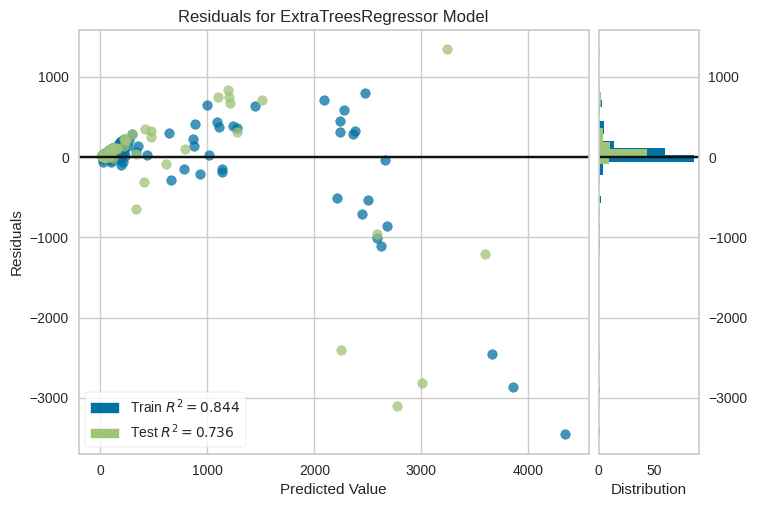

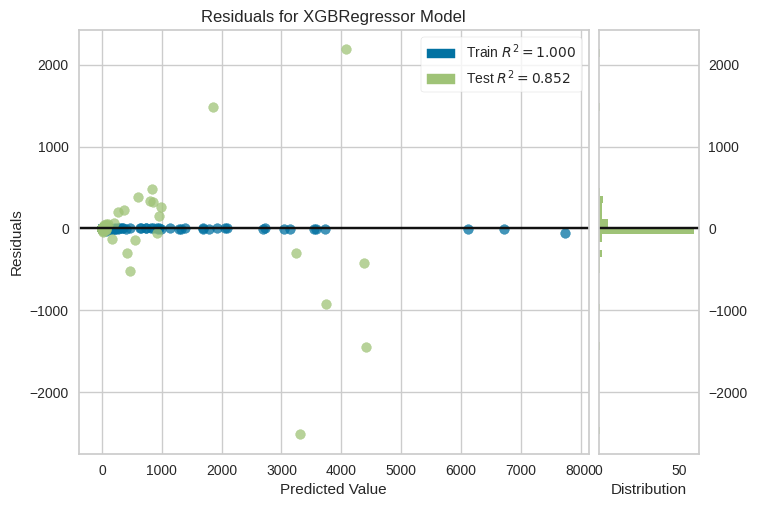

In [108]:
for tuned_mdl in [tuned_et,tuned_xg]:
  plot_model(tuned_mdl)

A dispersão dos resíduos no ET é maior do que no ADA.

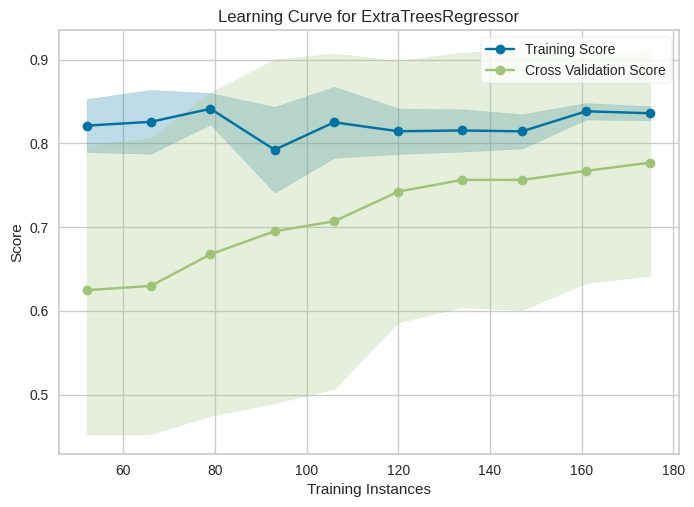

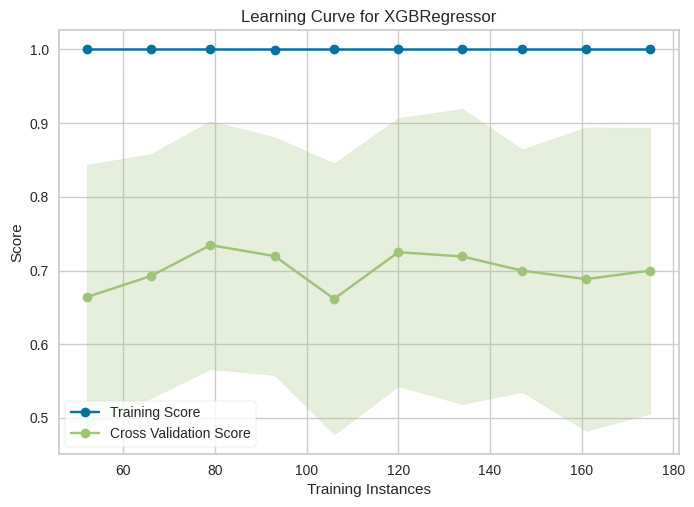

In [109]:
for tuned_mdl in [tuned_et, tuned_xg]:
  plot_model(tuned_mdl, plot = 'learning')

O modelo do xgboost aparenta ter sofrido overfitting por permanecer muito próximo do 100% de acerto na linha referente ao treino, por este motivo o modelo ET levou vantagem nessa validação final, já que apresentou quase uma convergência entre a linha de treino e de cross validation, ambas subindo  a medida que ocorria mais treinamento.

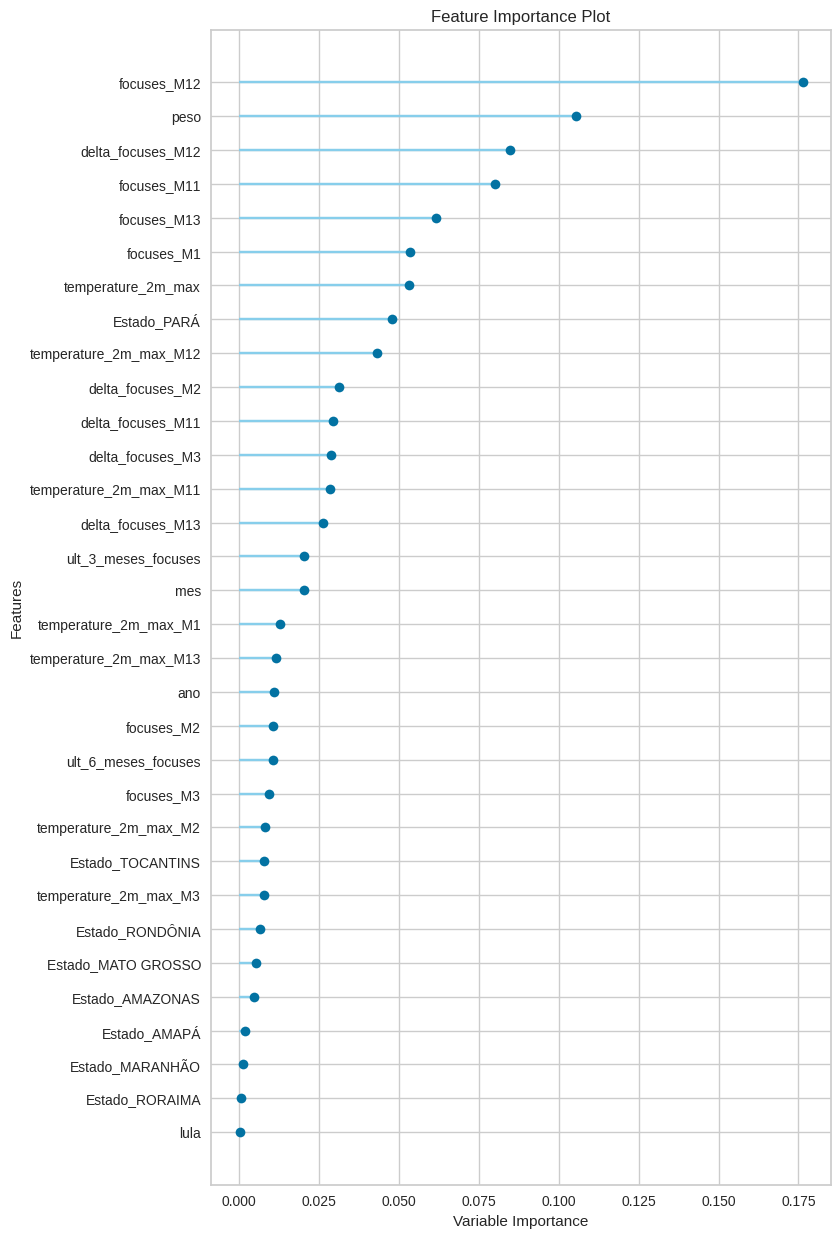

In [110]:
plot_model(tuned_et, plot = 'feature_all')

Aqui notamos a grande importância do trabalho de feature engineering, duas das três variáveis mais importantes foram criadas ao longo do processo, e a mais importante para o modelo et é justamente a quantidade de queimadas do mesmo mês que está sendo previsto referente ao ano anterior devivo a forte sazonalidade dos dados.

In [111]:
comp_models = []
# #gbr_R2
pred_et = predict_model(tuned_et)
r2_et = r2_score(pred_et['focuses'], pred_et['prediction_label'])
#append r2 em uma tabela comparativa
comp_models.append(('pycaret_GBR', np.round(r2_et,4)))

#rf_R2
pred_xg = predict_model(tuned_xg)
r2_xg= r2_score(pred_xg['focuses'], pred_xg['prediction_label'])
#append r2 em uma tabela comparativa
comp_models.append(('pycaret_RF', np.round(r2_xg,4)))

display(comp_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,253.7761,376933.2417,613.9489,0.7356,2.1118,11.5779


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,160.2943,210831.7344,459.1642,0.8521,0.8185,1.3563


[('pycaret_GBR', 0.7356), ('pycaret_RF', 0.8521)]

Apesar do modelo de xgboost aparentar ter sofrido um overfitting, quando passamos a trabalhar com a base de teste, o xg obteve um melhor desempenho em praticamente todas as métricas de comparação em relação ao et. E em algumas métricas obteve uma folga considerável. Por exemplo, no r² tivemos 0.85 do xg, contra 0.73 do ET. Portanto, seguiremos com o modelo xgboost.

In [112]:
finalize_model(tuned_xg)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['temperature_2m_max',
                                             'temperature_2m_max_M1',
                                             'temperature_2m_max_M2',
                                             'temperature_2m_max_M3',
                                             'temperature_2m_max_M11',
                                             'temperature_2m_max_M12',
                                             'temperature_2m_max_M13',
                                             'focuses_M1', 'focuses_M2',
                                             'focuses_M3', 'focuses_M11',
                                             'focuses_M12', 'focuses_M...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=70, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=123, ...))])

In [113]:
# save pipeline
save_model(tuned_xg, 'pycaret_mdl_xg')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['temperature_2m_max',
                                              'temperature_2m_max_M1',
                                              'temperature_2m_max_M2',
                                              'temperature_2m_max_M3',
                                              'temperature_2m_max_M11',
                                              'temperature_2m_max_M12',
                                              'temperature_2m_max_M13',
                                              'focuses_M1', 'focuses_M2',
                                              'focuses_M3', 'focuses_M11',
                                              'focuses_M12', 'focuses_M...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction

In [90]:
#df_futuro_dummy2.to_csv("dados_queimadas_previsao.csv")